## Setup

In [17]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

cm = 1/2.54  # centimeters in inches
scaling = 1
plt.rc("figure", figsize=(16*scaling*cm,7*scaling))

import poissonlearning as pl

import storage
import plotting

plotting.setup(latex=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
SAVE_PLOTS = False
NUM_PLOTTING_POINTS = 5000

### Convenience functions

In [19]:
def compute_analytic_solution(xy, z1, z2):
    # Compute the analytic continuum limit
    green_first_label = pl.datasets.one_circle.greens_function(x=xy, z=z1)
    green_second_label = pl.datasets.one_circle.greens_function(x=xy, z=z2)
    solution_analytic = -0.5 * green_first_label + 0.5 * green_second_label
    return solution_analytic


def compute_errors(experiments):
    for experiment in experiments:
        solution = experiment["solution"]
        xy = solution[["x", "y"]].to_numpy()
        z = solution["z"].to_numpy()

        z1 = experiment["label_locations"][0]
        z2 = experiment["label_locations"][1]
        analytic = compute_analytic_solution(xy, z1, z2)

        mask_infty = np.isfinite(analytic)

        error_L1 = np.abs(z[mask_infty] - analytic[mask_infty]).mean()
        experiment["error_L1"] = error_L1

        # Compute error to dirac experiment, if exists
        e_dirac = list(
            filter(
                lambda x: x["seed"] == experiment["seed"]
                and x["n"] == experiment["n"]
                and np.isclose(x["eps"], experiment["eps"])
                and np.allclose(x["label_locations"], experiment["label_locations"])
                and x["kernel"] == experiment["kernel"]
                and x["bump"] == "dirac",
                experiments,
            )
        )
        if e_dirac:
            error_L1_dirac = np.abs(solution["z"] - e_dirac[0]["solution"]["z"]).mean()
            experiment["error_L1_dirac"] = error_L1_dirac

### Load experiments and compute errors

In [4]:
experiments = storage.load_results(name="one_circle", folder="../results")
compute_errors(experiments)

## Plotting

### solution vs analytic

In [20]:
bump_width = "dirac"
n = 700000
ex_plot = list(
    filter(lambda x: 
        x["n"] == n 
        and x["bump"] == bump_width
        #and "eps" in x, 
        and "n_neighbors" in x, 
        experiments,
    )
)[0]

solution_plot = ex_plot["solution"]
sample = solution_plot.sample(NUM_PLOTTING_POINTS, random_state=1)

xy = sample[["x", "y"]].to_numpy()
dist = cdist(xy, xy, metric="euclidean")

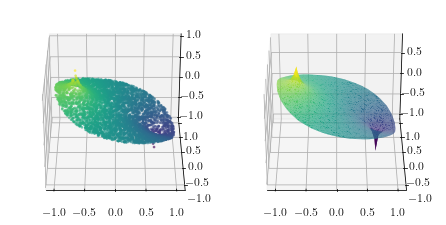

In [21]:
fig = plt.figure()
ax_solution = fig.add_subplot(1, 2, 1, projection="3d")
plotting.plot_graph_function_scatter(
    ax_solution, xy, sample["z"].to_numpy(), dist=dist, max_dist=0.1,
)

z1 = ex_plot["label_locations"][0]
z2 = ex_plot["label_locations"][1]
analytic = compute_analytic_solution(xy, z1, z2)
ax_analytic = fig.add_subplot(1, 2, 2, projection="3d")
plotting.plot_graph_function_with_triangulation(
    ax_analytic, xy, analytic, dist=dist, max_dist=0.1,
)
# fig_results.suptitle(f"Discrete solution [n={n}] vs analytic solution")
fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../plots/one_circle_demo.png", bbox_inches="tight")

### Error for Dirac RHS

In [7]:
selected_experiments = {
    kernel: list(
        filter(
            lambda x: x["kernel"] == kernel
            and x["bump"] == "dirac"
            and "eps" in x
            and (
                x["n"] != 100000 or np.isclose(x["eps"], 0.00930454)
            ),  # Keep only eps = np.log(n) ** (1 / 15) * conn_radius
            experiments,
        )
    )
    for kernel in ["gaussian"]
}

n_error = sorted(list(set([e["n"] for e in list(selected_experiments.values())[0]])))
error = {kernel: {} for kernel in selected_experiments.keys()}
for kernel, experiments_with_kernel in selected_experiments.items():
    for n in n_error:
        ex = list(filter(lambda x: x["n"] == n, experiments_with_kernel))
        error[kernel][n] = {}
        error[kernel][n]["mean"] = np.mean([e["error_L1"] for e in ex])
        error[kernel][n]["max"] = np.max([e["error_L1"] for e in ex])
        error[kernel][n]["min"] = np.min([e["error_L1"] for e in ex])

/home/max/Dokumente/Studium/Masterarbeit/code/poisson_learning/examples/plotting.py:121: RuntimeWarning: overflow encountered in power
  return a * (X ** (-n))


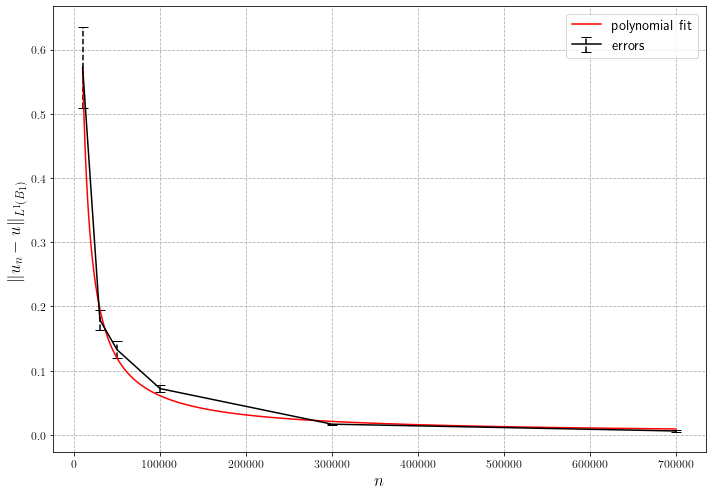

In [8]:
fig, ax = plt.subplots(1, 1)
plotting.error_plot(error, ax, fit="polynomial")
# ax_error.set_title(f"L1 Error compared with RHS {bump_width} to analytic solution")
ax.legend()
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\lVert u_n - u \rVert_{L^1 \left(B_1 \right)}$")
fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../plots/one_circle_dirac_n.pdf", bbox_inches="tight")

### Convergence of bump RHS

In [9]:
n = 700000
selected_experiments = {
    kernel: list(
        filter(
            lambda x: x["kernel"] == kernel and x["n"] == n
            and "eps" in x, 
            experiments,
        )
    )
    for kernel in ["gaussian"]
}

bump_error = list(set([e["bump"] for e in list(selected_experiments.values())[0]]))
bump_error = sorted([b for b in bump_error if isinstance(b, float)])
error = {kernel: {} for kernel in selected_experiments.keys()}
for kernel, experiments_with_kernel in selected_experiments.items():
    for bump in bump_error:
        ex = list(filter(lambda x: x["bump"] == bump, experiments_with_kernel))
        bump_inv = 1.0 / bump
        error[kernel][bump_inv] = {}
        error[kernel][bump_inv]["mean"] = np.mean([e["error_L1_dirac"] for e in ex])
        error[kernel][bump_inv]["max"] = np.max([e["error_L1_dirac"] for e in ex])
        error[kernel][bump_inv]["min"] = np.min([e["error_L1_dirac"] for e in ex])

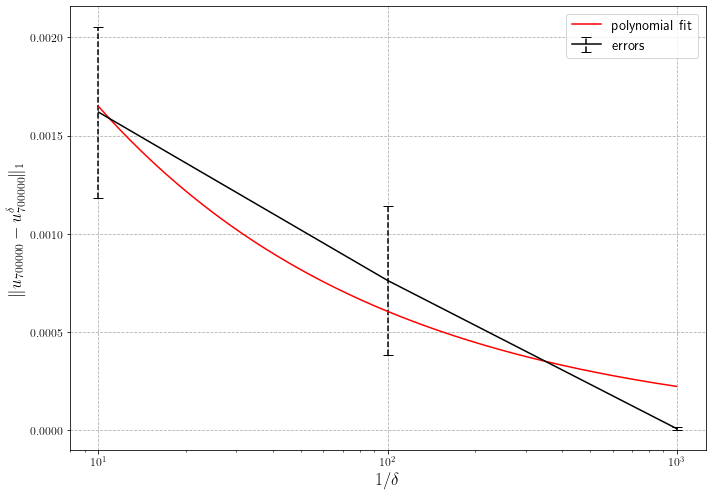

In [10]:
for kernel, e in error.items():
    fig, ax = plt.subplots(1, 1)
    plotting.error_plot({kernel: e}, ax, fit="polynomial")

    # ax.set_xscale("log")
    # ax.set_title("L1 error of solution with dirac RHS")
    ax.legend()
    ax.set_xlabel(r"$1/\delta$")
    ax.set_ylabel(fr"$\lVert u_{ {n} } - u_{ {n} }^\delta \rVert_1$")
    ax.set_xscale("log")

    fig.tight_layout()
    if SAVE_PLOTS:
        fig.savefig(f"../plots/one_circle_delta_{kernel}.pdf", bbox_inches="tight")

### Convergence for different choices of epsilon

In [11]:
n = 100000
selected_experiments = {
    kernel: list(
        filter(
            lambda x: x["kernel"] == kernel
            and x["n"] == n
            and x["bump"] == "dirac"
            and "eps" in x,
            experiments,
        )
    )
    for kernel in ["gaussian"]
}
eps_error = list(set([e["eps"] for e in list(selected_experiments.values())[0]]))
eps_error = sorted(eps_error)
error = {kernel: {} for kernel in selected_experiments.keys()}
n_connected_component = {kernel: {} for kernel in selected_experiments.keys()}
for kernel, experiments_with_kernel in selected_experiments.items():
    for eps in eps_error:
        ex = list(filter(lambda x: np.isclose(x["eps"], eps), experiments_with_kernel))
        error[kernel][eps] = {}
        error[kernel][eps]["mean"] = np.mean([e["error_L1"] for e in ex])
        error[kernel][eps]["max"] = np.max([e["error_L1"] for e in ex])
        error[kernel][eps]["min"] = np.min([e["error_L1"] for e in ex])

        n_connected_component[kernel][eps] = {}
        n_connected_component[kernel][eps]["mean"] = np.mean([e["solution"].shape[0] for e in ex])
        n_connected_component[kernel][eps]["max"] = np.max([e["solution"].shape[0] for e in ex])
        n_connected_component[kernel][eps]["min"] = np.min([e["solution"].shape[0] for e in ex])

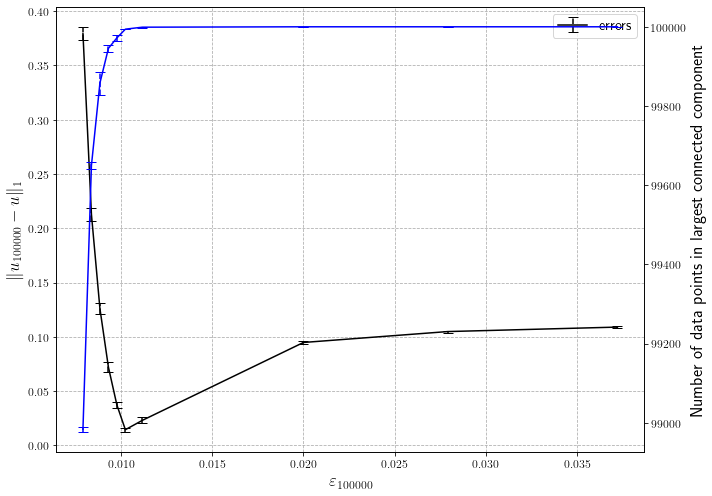

In [12]:
for kernel, e in error.items():
    fig, ax = plt.subplots(1, 1)
    plotting.error_plot({kernel: e}, ax)#, fit="polynomial")

    ax.legend()
    ax.set_xlabel(fr"$h_{ {n} }$")
    ax.set_ylabel(fr"$\lVert u_{ {n} } - u \rVert_1$")
    #ax.set_xscale("log")

    ax_n = ax.twinx()
    plotting.error_plot({kernel: n_connected_component[kernel]}, ax_n, c="blue")#, fit="polynomial")
    ax_n.grid(None)
    ax_n.set_ylabel(r"Number of data points in largest connected component")

    fig.tight_layout()
    if SAVE_PLOTS:
        fig.savefig(f"../plots/one_circle_eps_{kernel}.pdf", bbox_inches="tight")